In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import lightning.pytorch as pl
from amplfi.train.cli.flow import AmplfiFlowCLI
import os
import torch
from gwpy.timeseries import TimeSeries

In [2]:
from jsonargparse import capture_parser
os.environ['AMPLFI_OUTDIR'] = '/home/ethan.marx/amplfi/mdc-testing/dev'
os.environ['AMPLFI_DATADIR'] = '/home/ethan.marx/amplfi/data/'
ckpt_path = '/home/ethan.marx/amplfi/best-hparams-long-run/train_logs/best.ckpt'
parser = capture_parser(AmplfiFlowCLI)
config = parser.parse_args(["fit", "--config", '/home/ethan.marx/amplfi/mdc-testing/cbc.yaml', "--model.checkpoint", ckpt_path])
config_init = parser.instantiate_classes(config)

/home/ethan.marx/miniconda3/envs/amplfi-no-7Ry-v-py3.9/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'arch' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['arch'])`.


2024-10-24 05:22:45,547 - FlowModel - INFO - Loading model weights from checkpoint path: /home/ethan.marx/amplfi/best-hparams-long-run/train_logs/best.ckpt


/home/ethan.marx/projects/amplfi/amplfi/train/models/base.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint, map_location=map_location)

2024-10-24 05:22:46,733 - root - INFO - Downloading data to /home/ethan.marx/amplfi/data/


In [3]:
from unittest.mock import Mock
datamodule = config_init.fit.data
model = config_init.fit.model
datamodule.trainer = Mock()
datamodule.trainer.device_ids = [0]
datamodule.trainer.lightning_module = config_init.fit.model

In [4]:
datamodule.setup(stage="fit")

2024-10-24 05:22:49,884 - AmplfiDataset - INFO - Setting up data for stage fit
2024-10-24 05:22:49,887 - AmplfiDataset - INFO - Inferred sample rate of 2048.0 Hz
2024-10-24 05:22:50,336 - AmplfiDataset - INFO - Loaded background files ['/home/ethan.marx/amplfi/data/train/background/background-1241437182-6601.hdf5', '/home/ethan.marx/amplfi/data/train/background/background-1241417182-20000.hdf5'] for validation
2024-10-24 05:23:11,611 - AmplfiDataset - INFO - Loaded 10000 waveforms for validation
2024-10-24 05:23:11,638 - AmplfiDataset - INFO - Building torch Modules and transferring to device
2024-10-24 05:23:11,642 - AmplfiDataset - INFO - Fitting standard scaler to parameters


In [5]:
test_dataloader = datamodule.test_dataloader()
test_dataloader = iter(test_dataloader)

strain = []
parameters = []
for s, p in test_dataloader:
    strain.append(s)
    parameters.append(p)
strain = torch.cat(strain)
parameters = torch.cat(parameters)

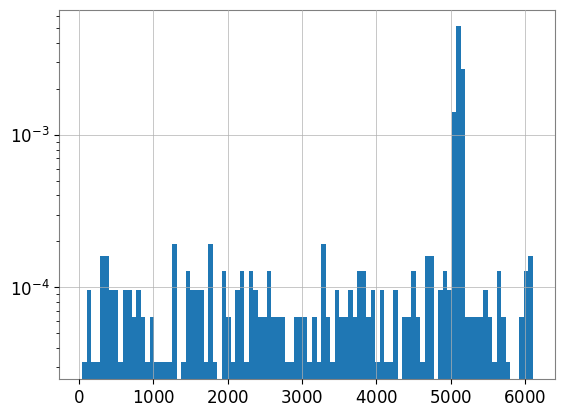

In [18]:
mdc_argmax = np.argmax(np.abs(strain[:, 0, :].numpy()), axis=-1)
plt.hist(mdc_argmax, bins=100, density=True)
plt.yscale("log")

In [6]:
idx = 0
print("Analyzing event with chirp mass: ", parameters[idx][0].item())
print("Analyzing event with mass ratio: ", parameters[idx][1].item())
print("Analyzing event with distance: ", parameters[idx][2].item())

Analyzing event with chirp mass:  35.37803268432617
Analyzing event with mass ratio:  0.5865792632102966
Analyzing event with distance:  1391.3551025390625


/home/ethan.marx/miniconda3/envs/amplfi-no-7Ry-v-py3.9/lib/python3.9/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 1024.00 is too high for the given Q range, resetting to 645.53
  warnings.warn('upper frequency of %.2f is too high for the given '
/home/ethan.marx/miniconda3/envs/amplfi-no-7Ry-v-py3.9/lib/python3.9/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 1024.00 is too high for the given Q range, resetting to 645.53
  warnings.warn('upper frequency of %.2f is too high for the given '


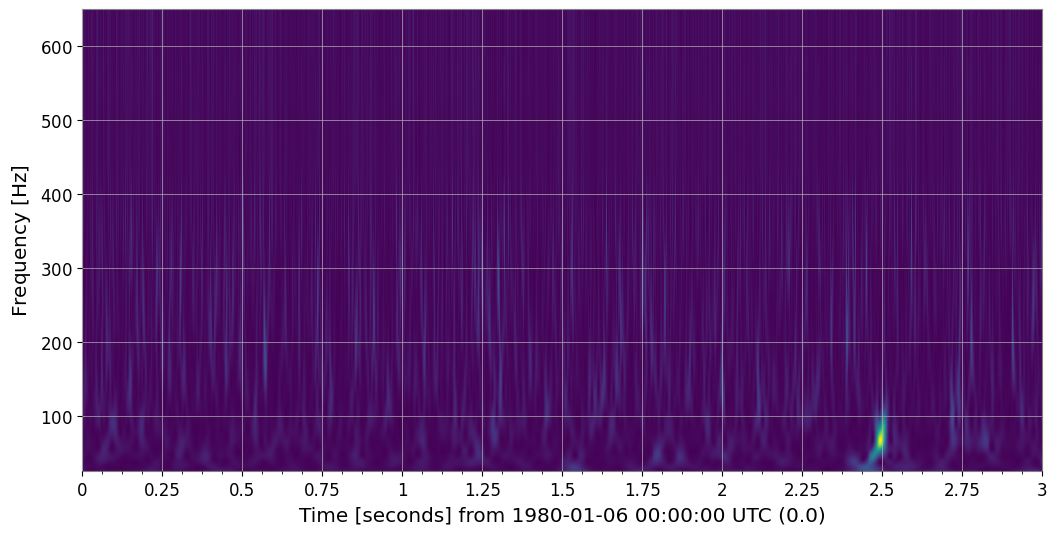

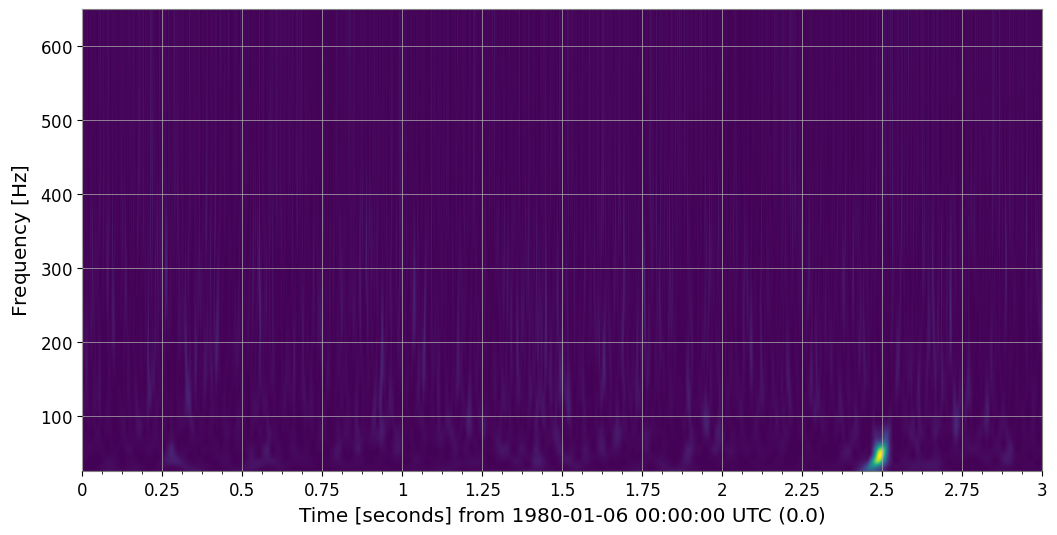

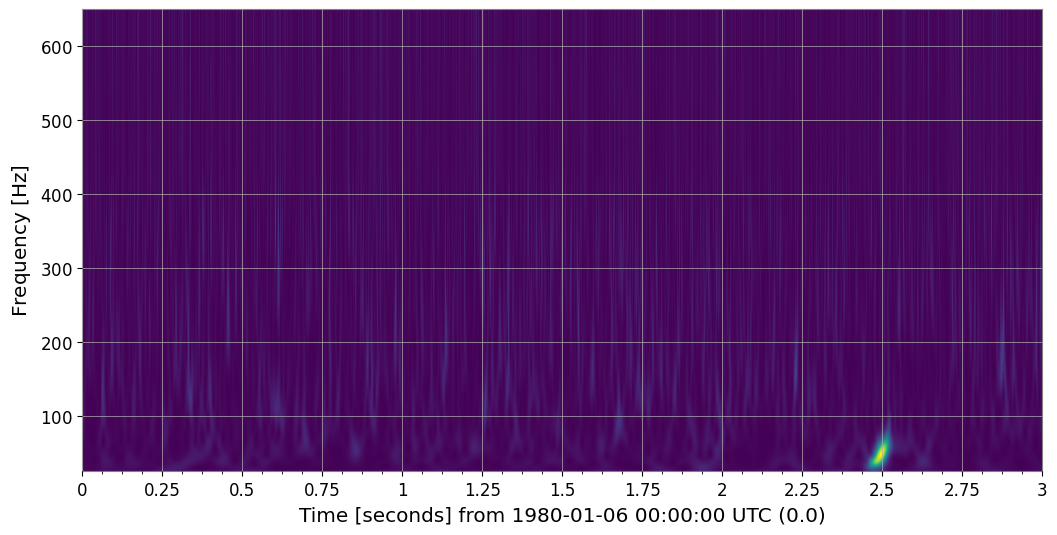

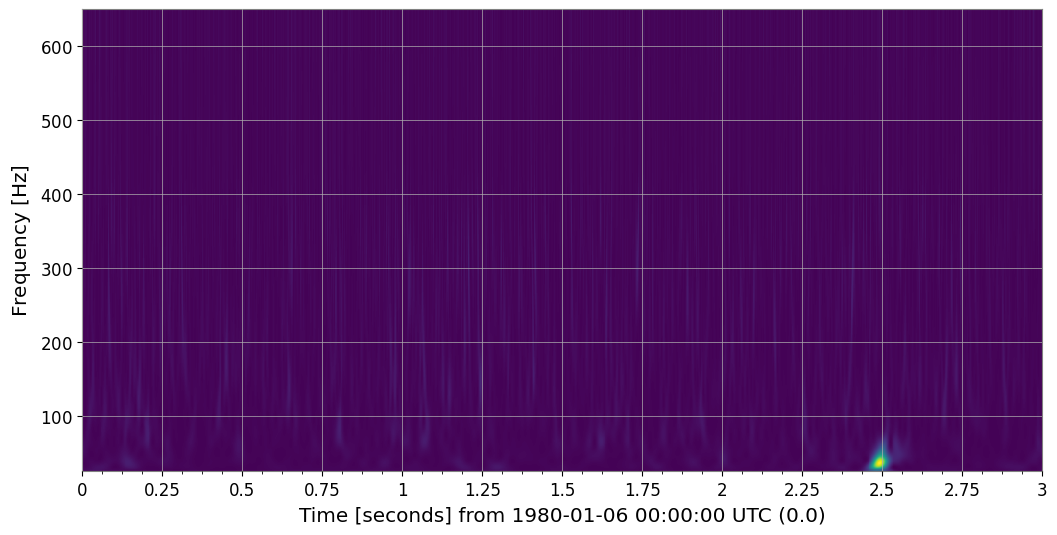

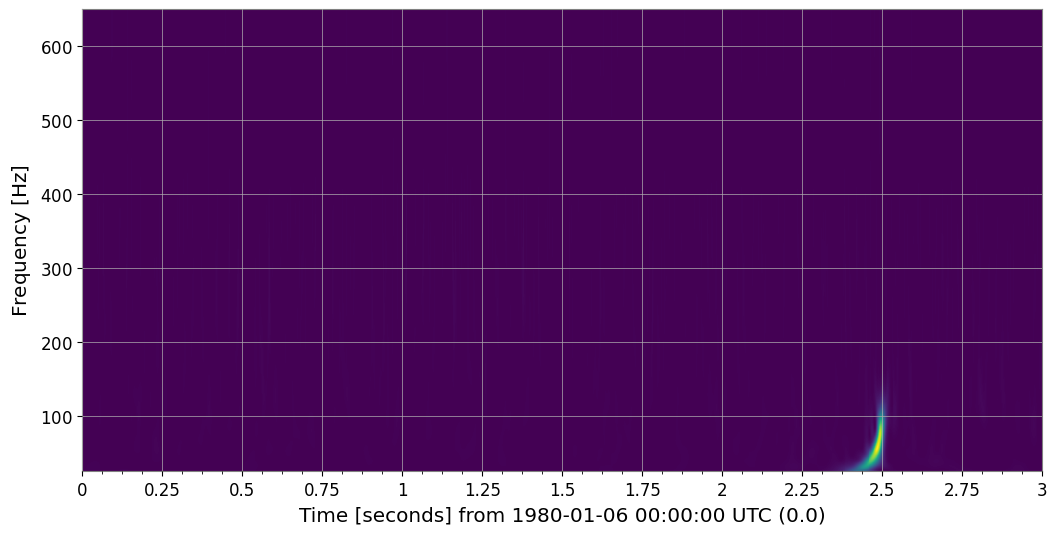

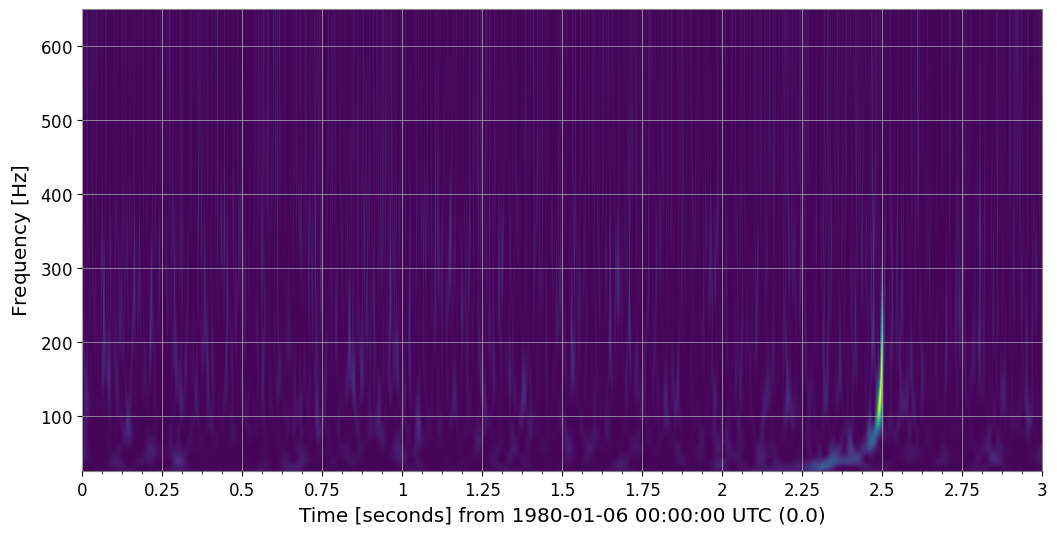

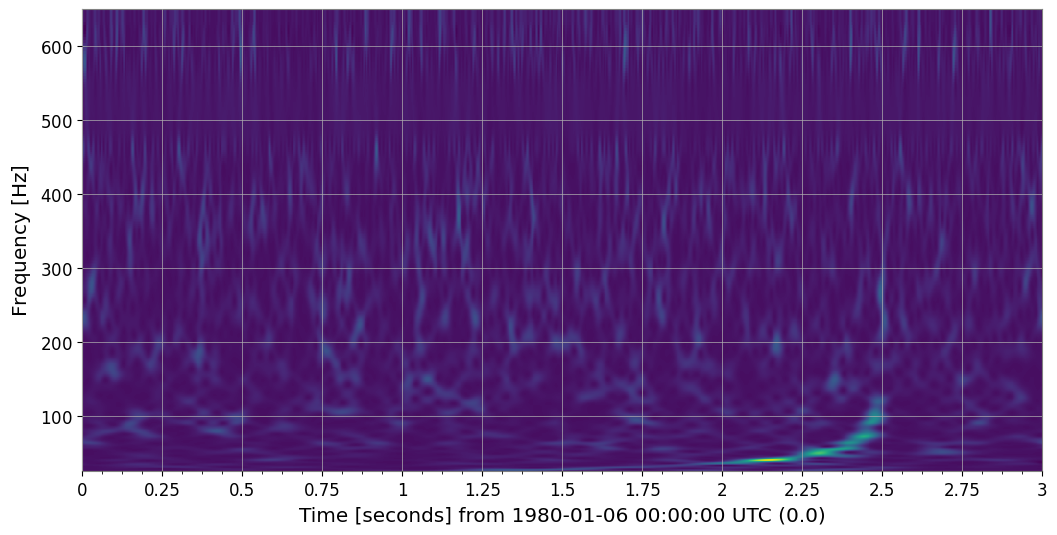

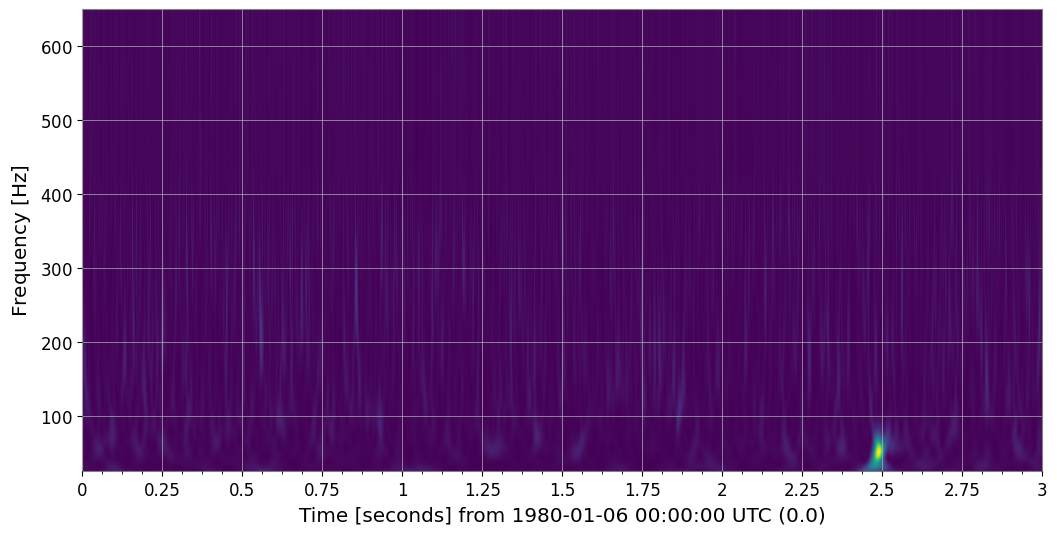

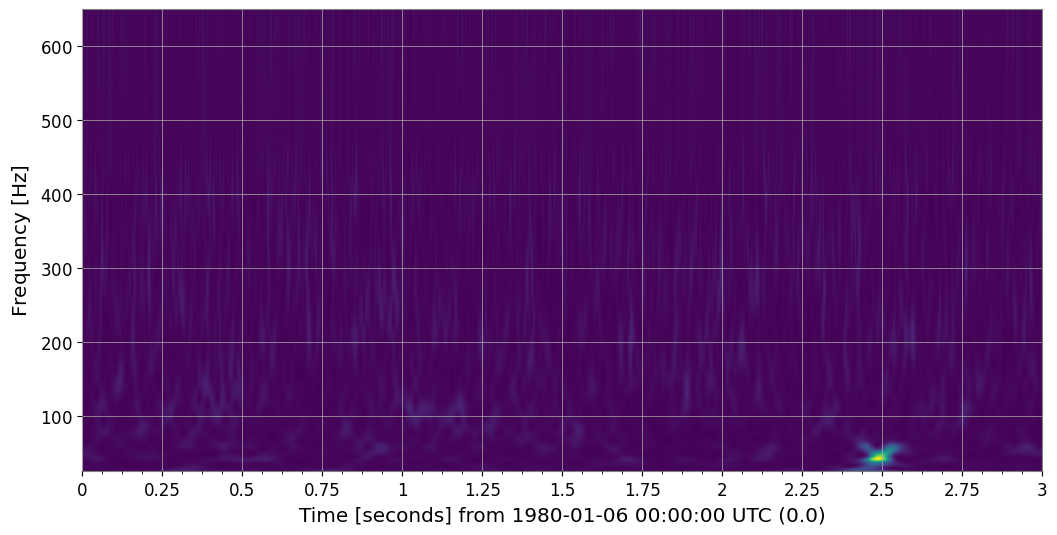

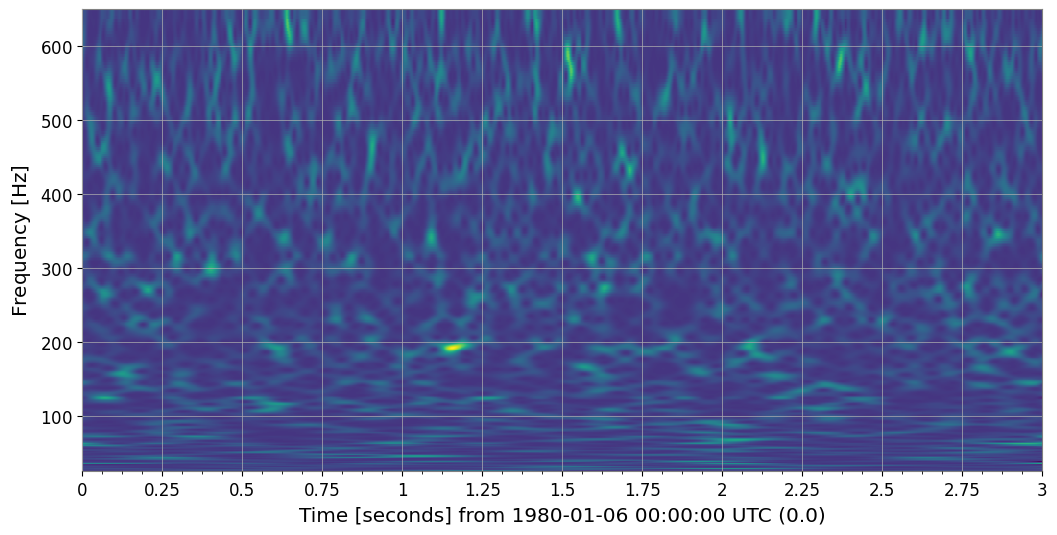

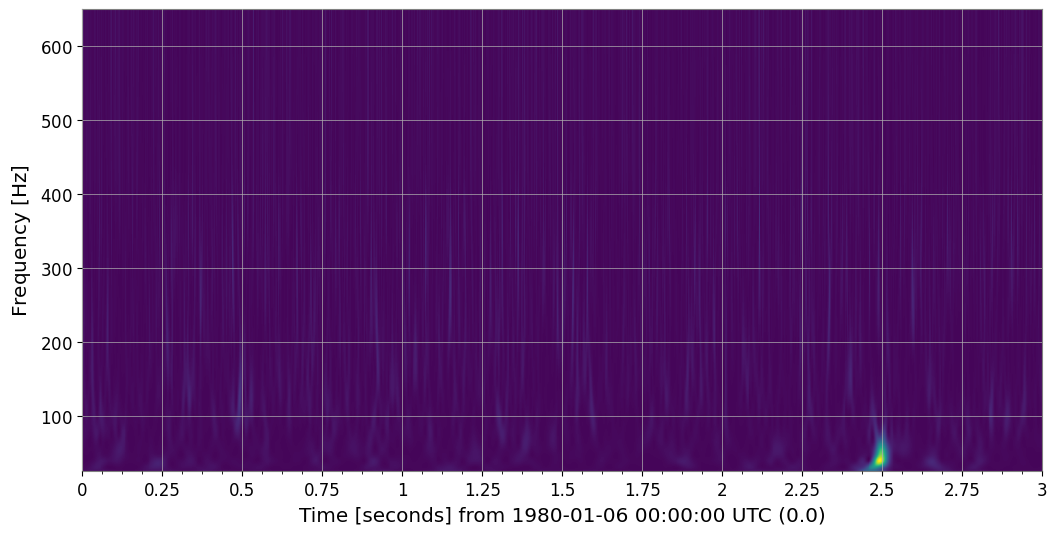

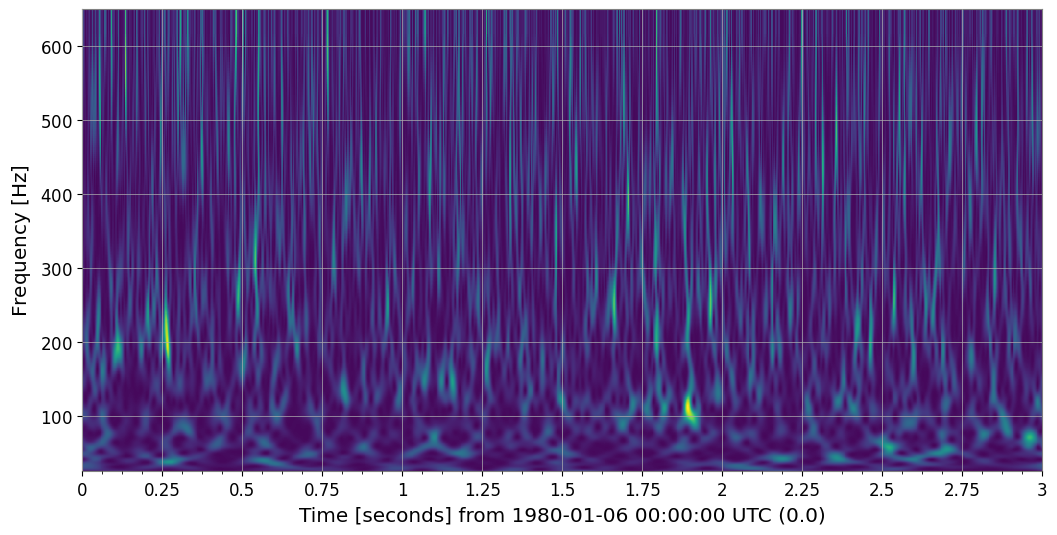

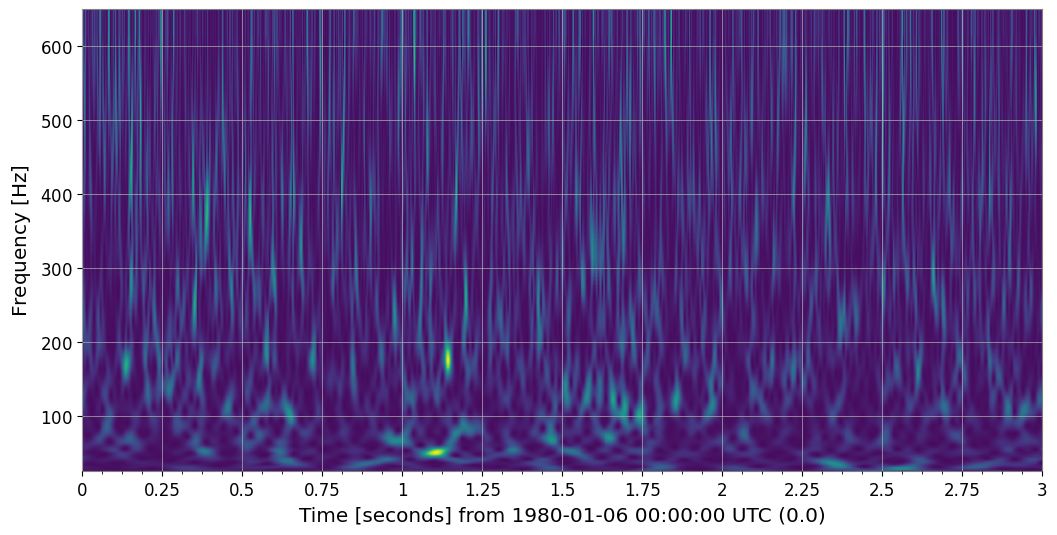

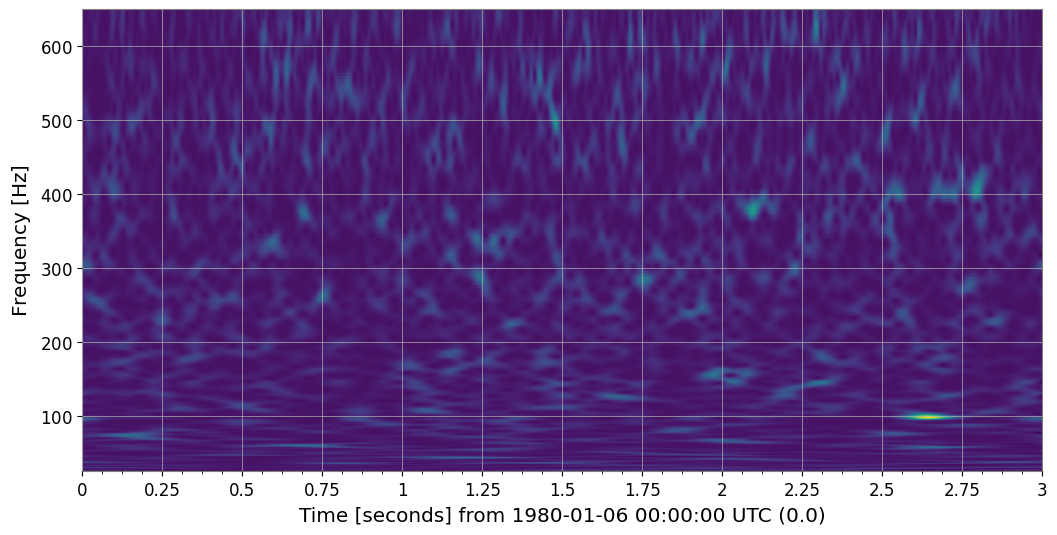

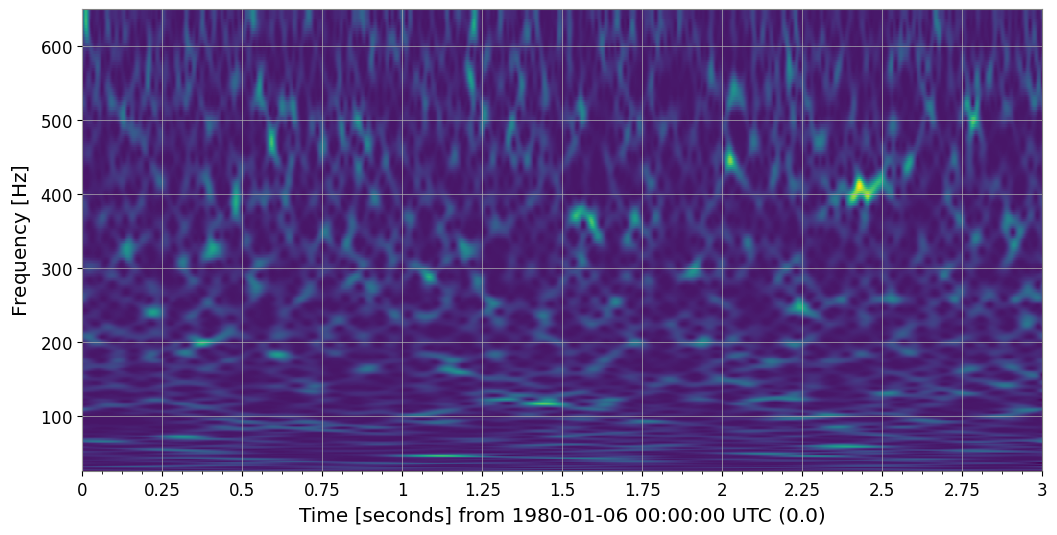

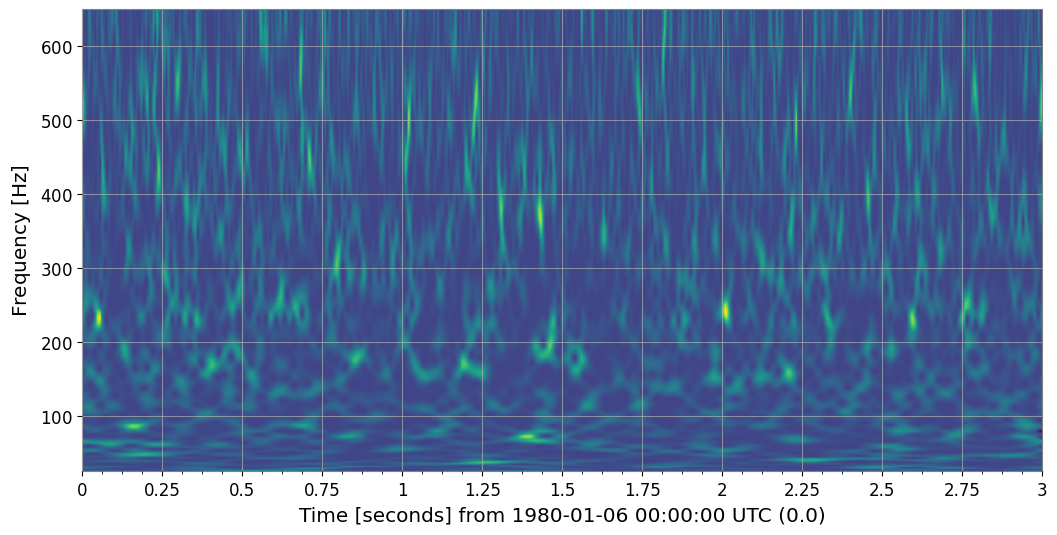

In [7]:
for idx in range(16):
    s, a, p = datamodule.on_after_batch_transfer( (strain[idx][None], parameters[idx][None]), _)
    TimeSeries(s[0][1].numpy(), sample_rate=2048).q_transform(whiten=False, frange=(25, 1024), logf=True).plot()

In [ ]:
from gwpy.timeseries import TimeSeries

In [13]:
samples = model.model.sample(10000, context=(s, a))
descaled = datamodule.scale(samples, reverse=True)

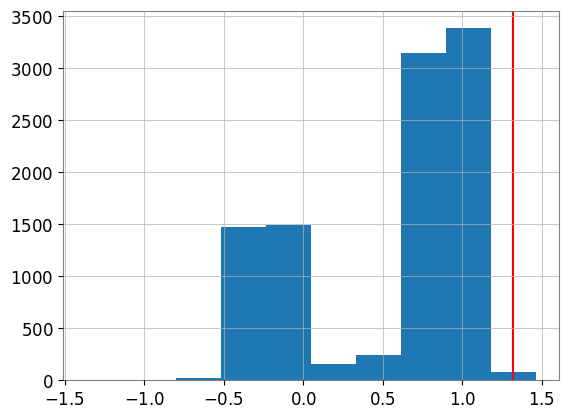

In [16]:
plt.hist(descaled[:,5])
#plt.hist(samples[:,7])
plt.axvline(parameters[idx][5].item(), color='r')

In [19]:
# investigate normal training data
train_dataloader = datamodule.train_dataloader()
train_dataloader = iter(train_dataloader)
strain = next(train_dataloader)

2024-10-24 05:27:33,087 - AmplfiDataset - INFO - Using a Hdf5TimeSeriesDataset class for training


In [27]:
[batch] = strain
cross, plus, train_parameters = datamodule.waveform_sampler.sample(batch)
train_strain, asds, train_parameters = datamodule.inject(
    batch, cross, plus, train_parameters
)


In [34]:
s, a  = train_strain[0], asds[0]
samples = model.model.sample(10000, context=(s[None], a[None]))
descaled = datamodule.scale(samples, reverse=True)
parameters = datamodule.scale(train_parameters, reverse=True)

In [33]:
train_parameters.shape

torch.Size([512, 8])

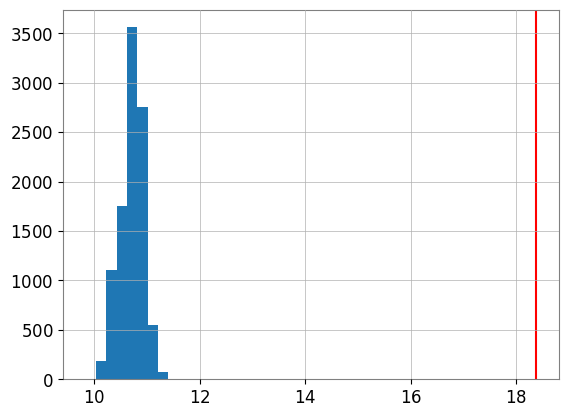

In [36]:
plt.hist(descaled[:,0])
plt.axvline(parameters[0][0].item(), color='r')

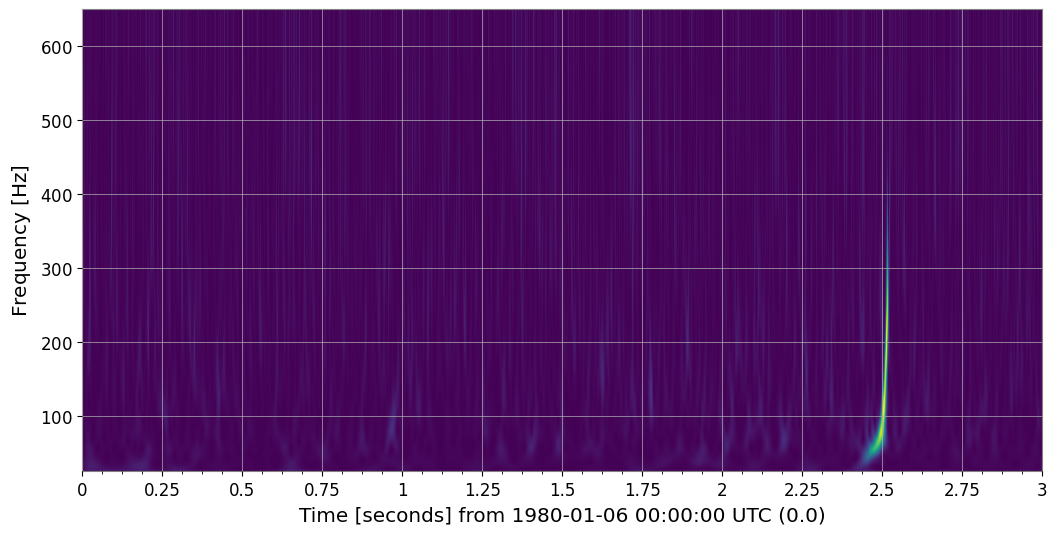

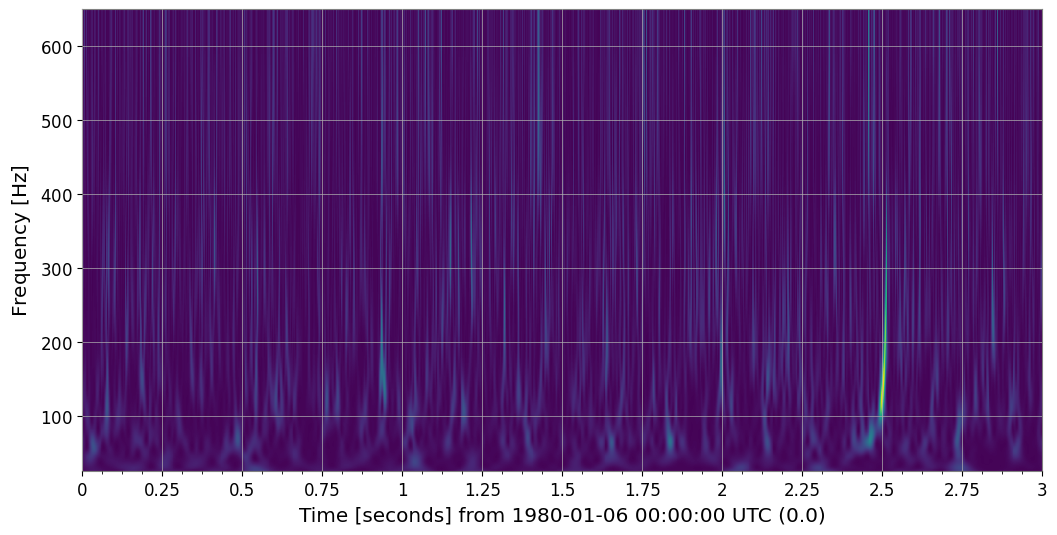

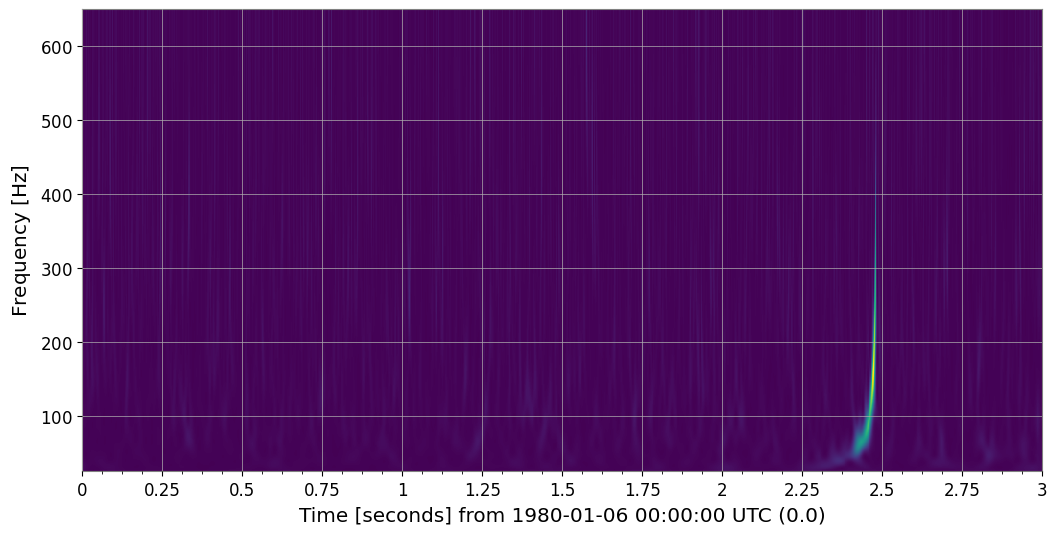

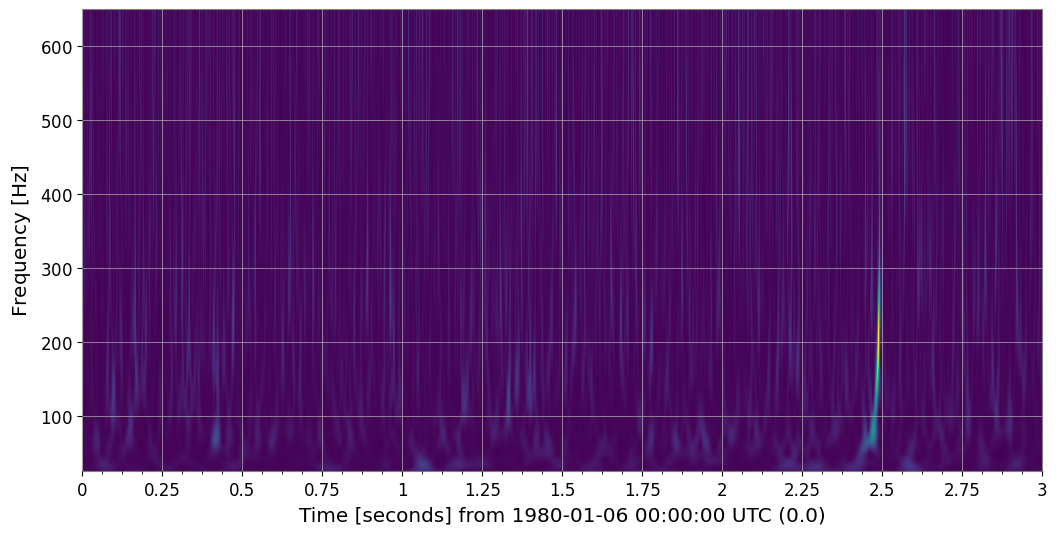

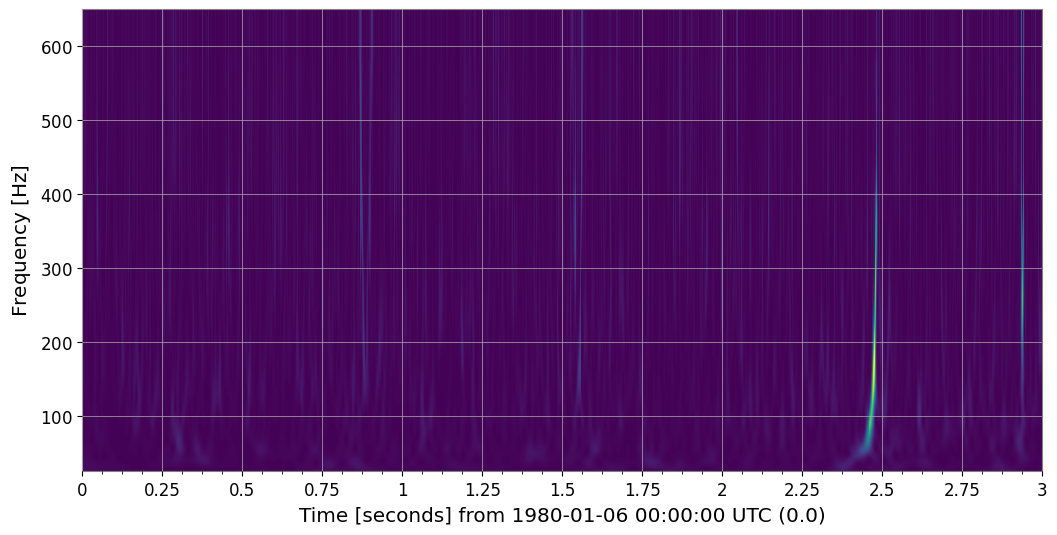

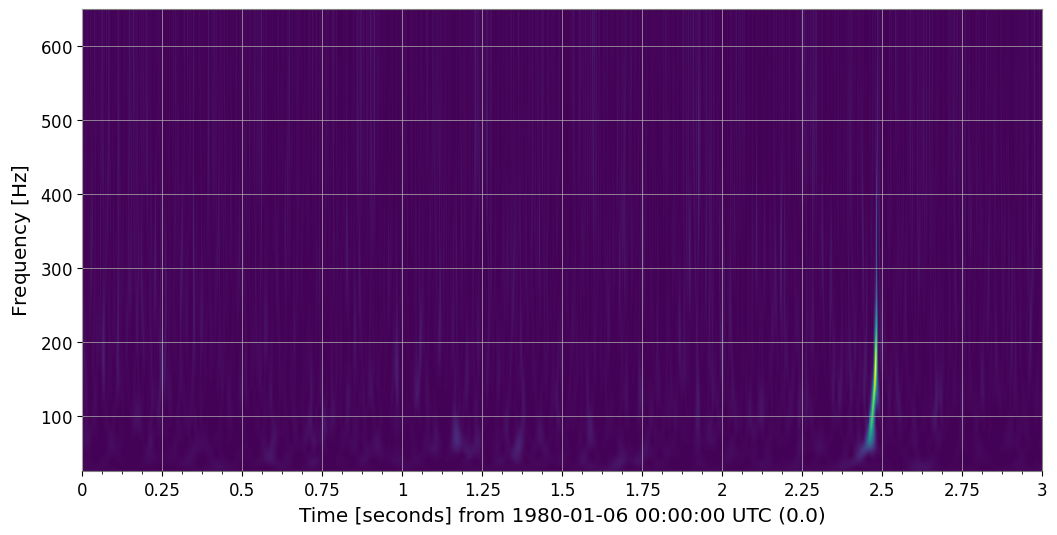

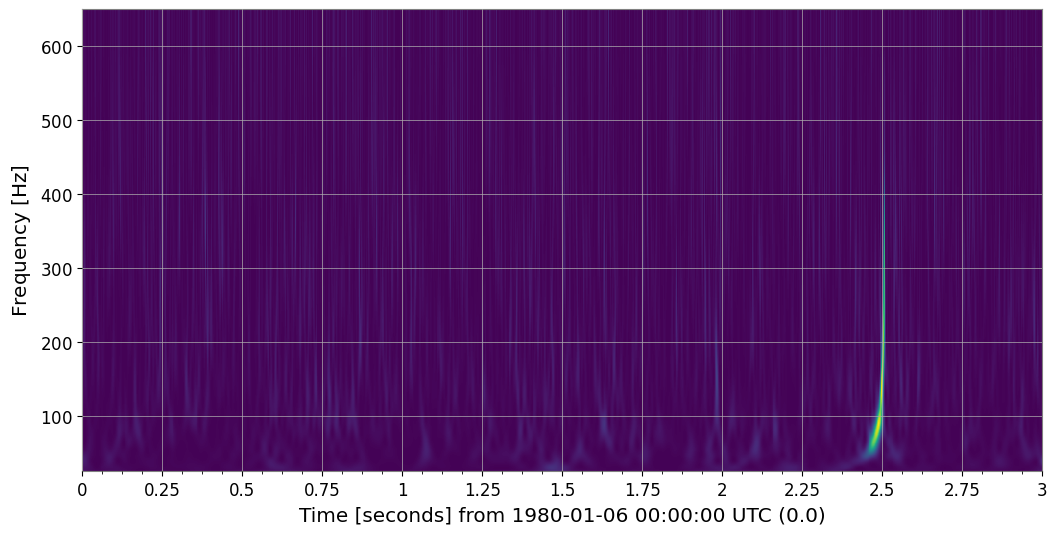

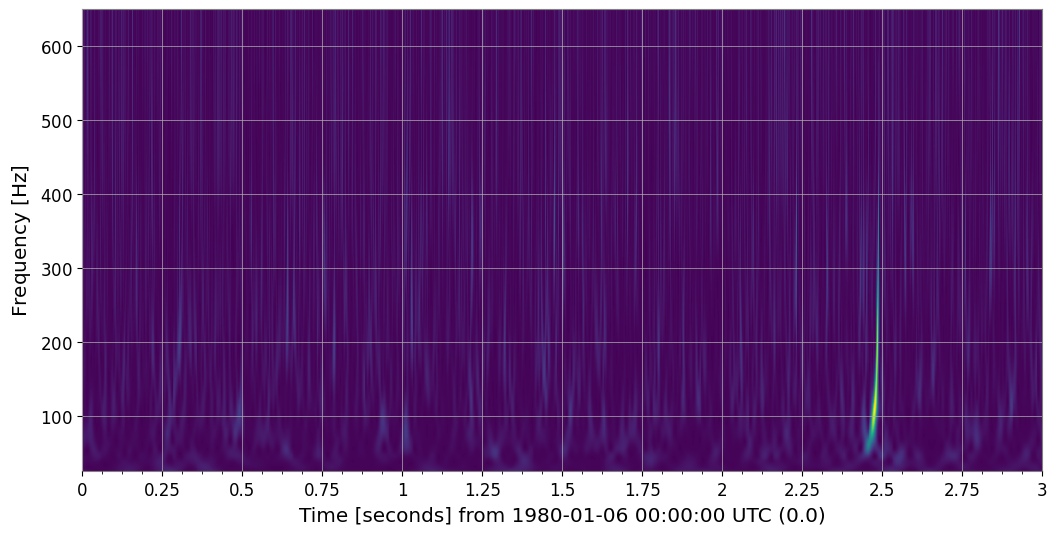

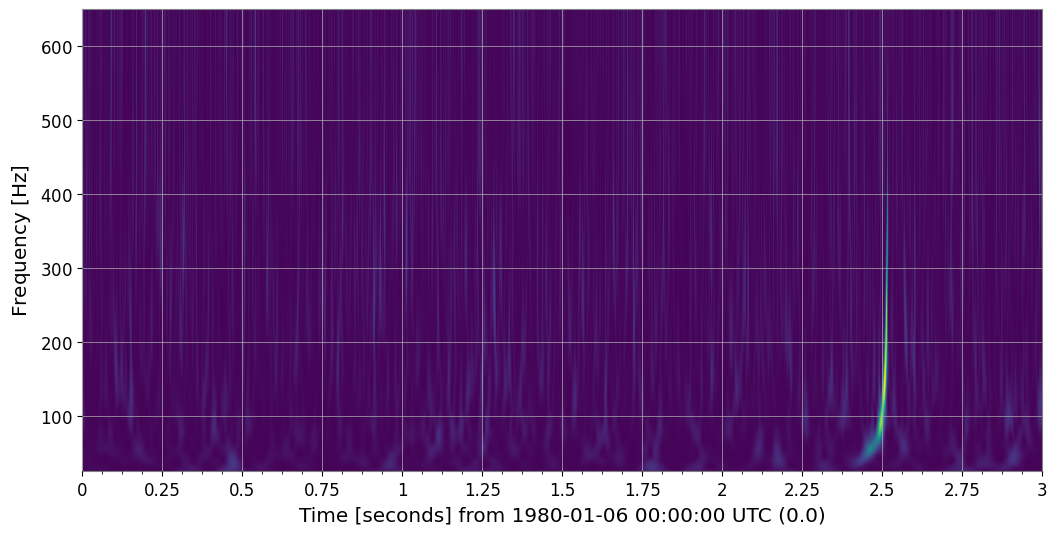

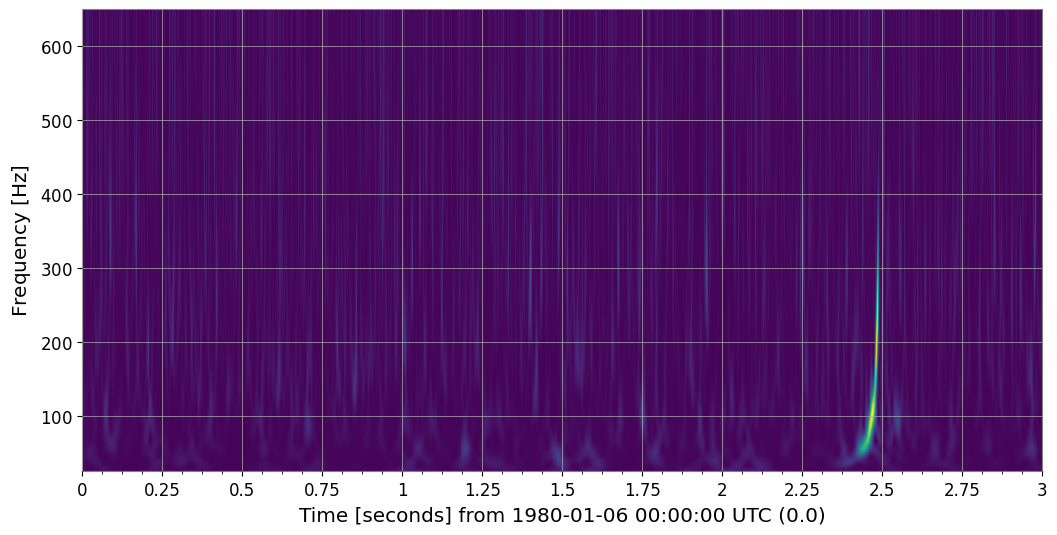

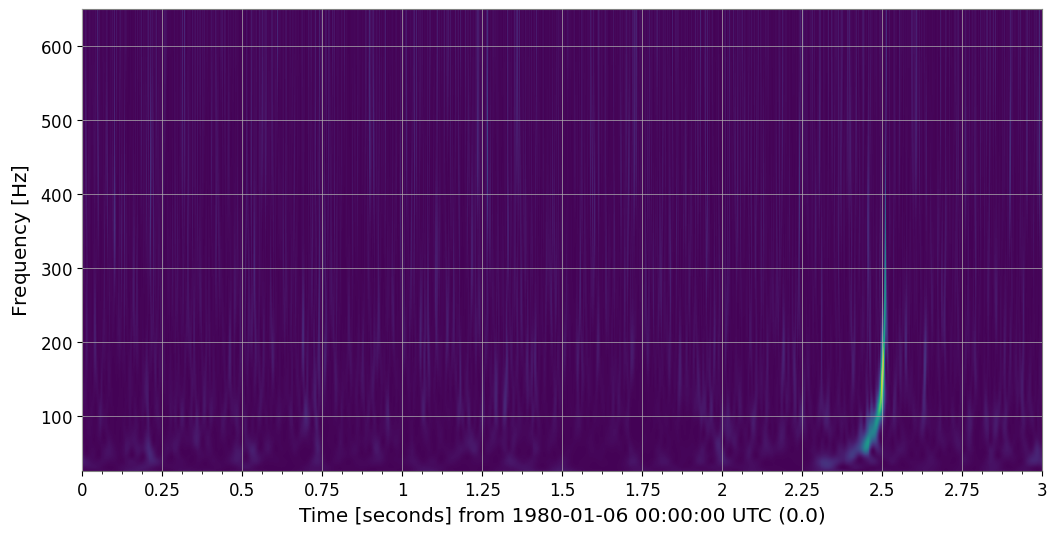

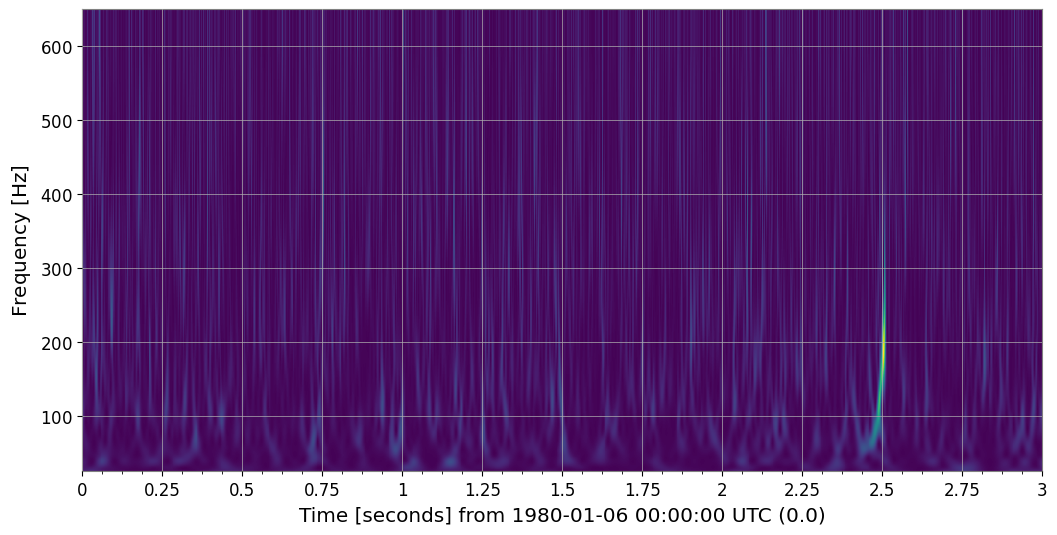

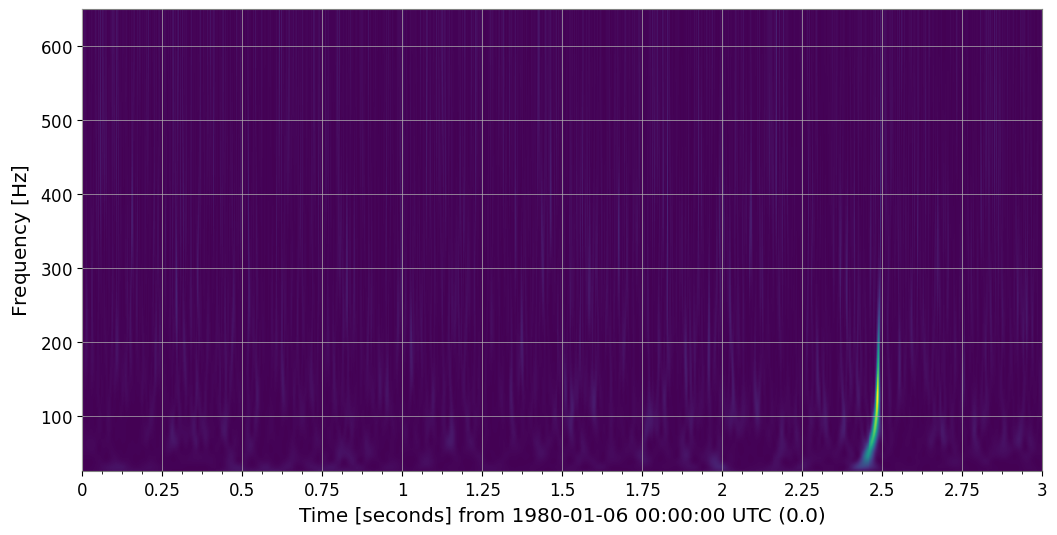

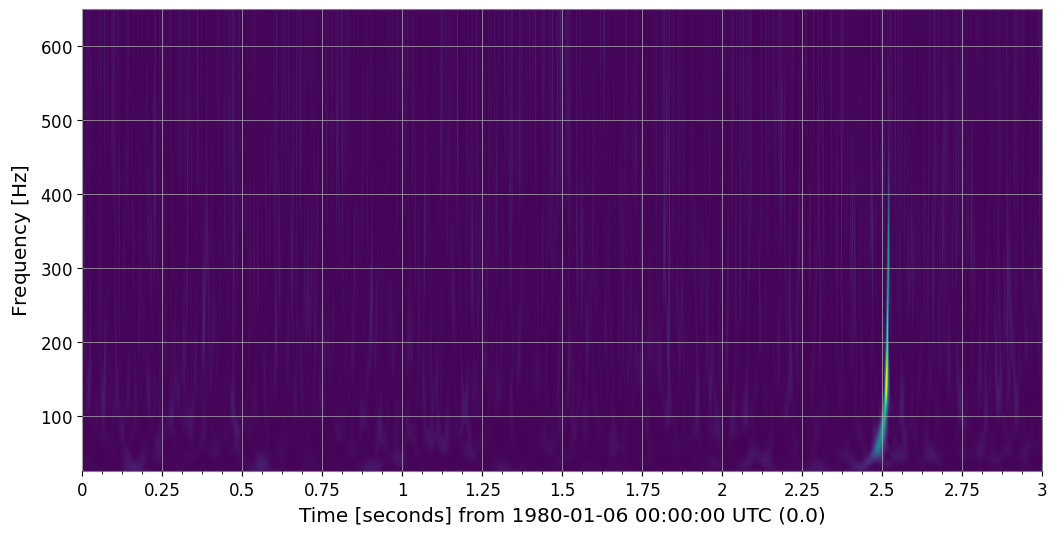

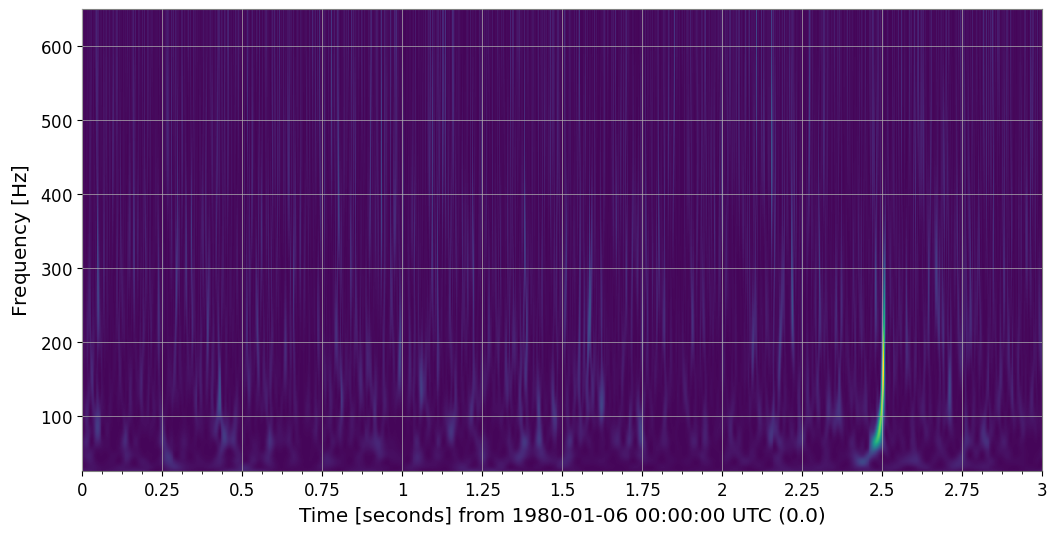

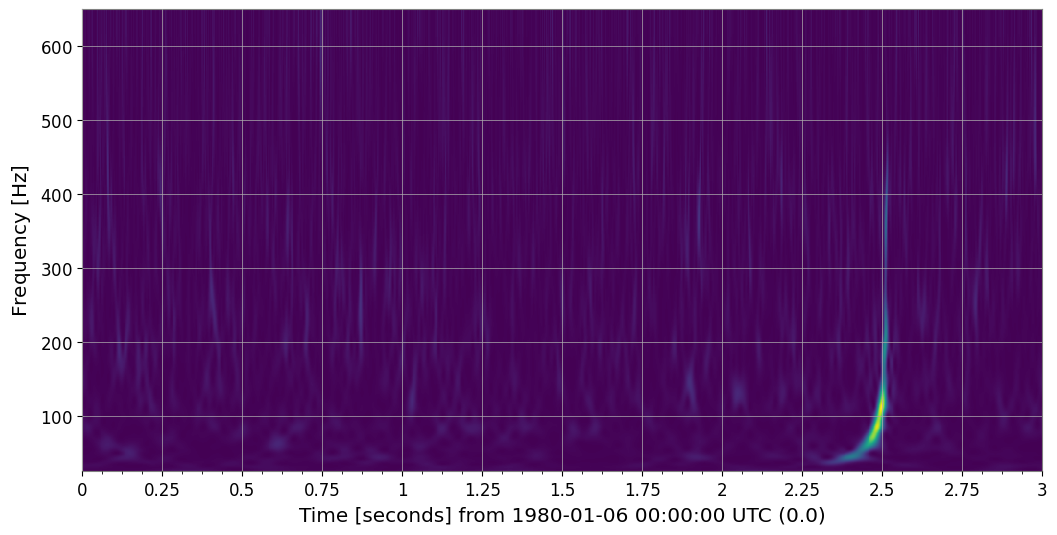

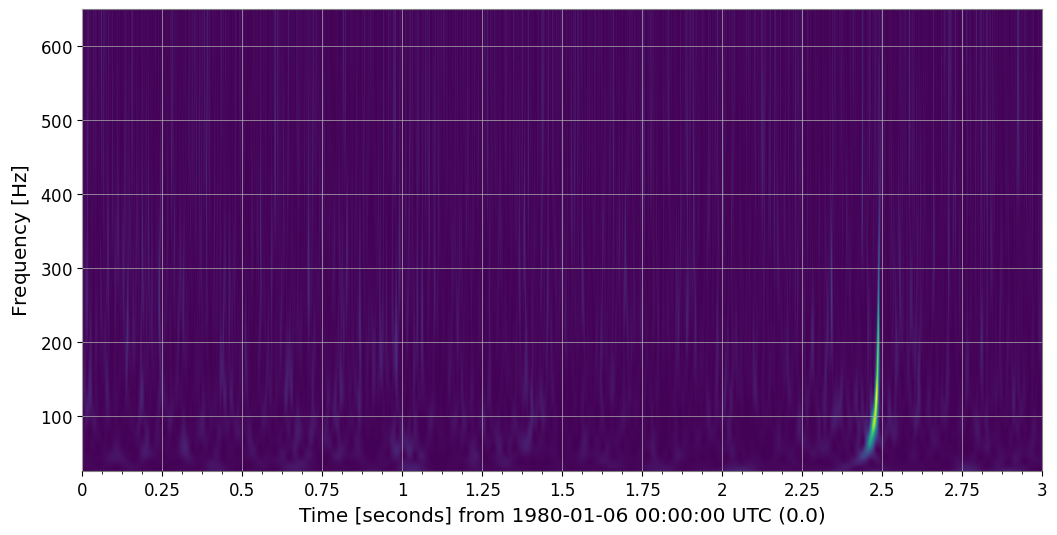

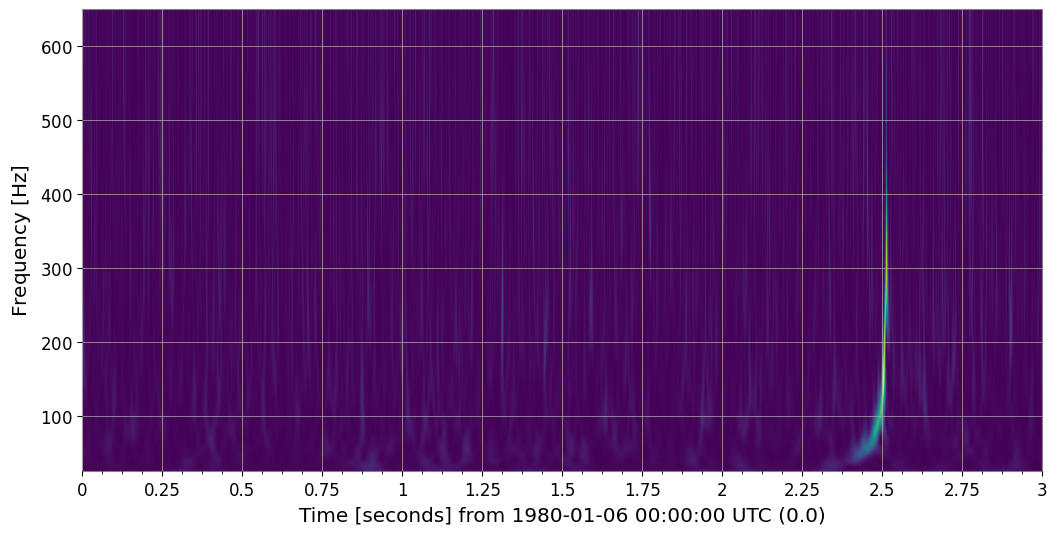

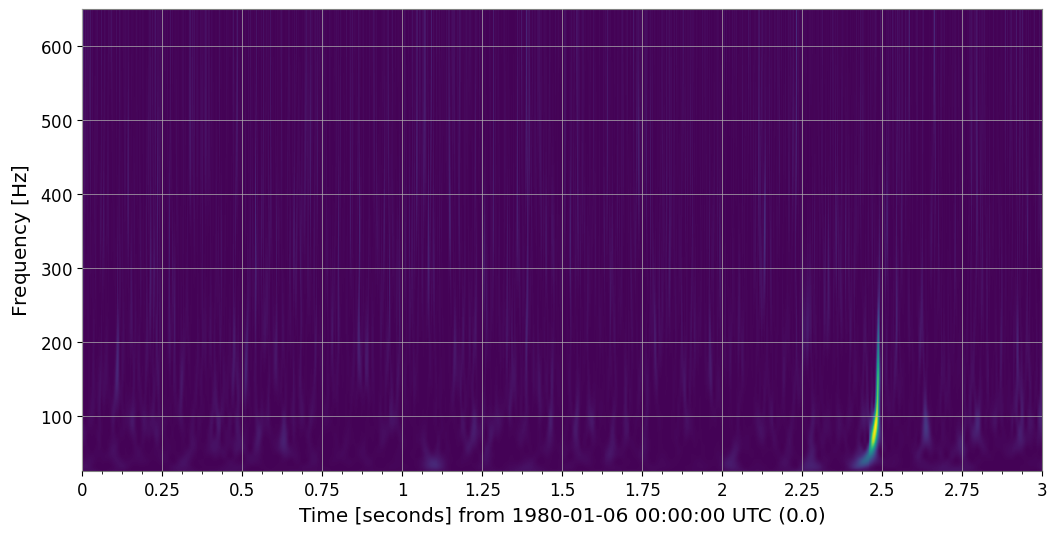

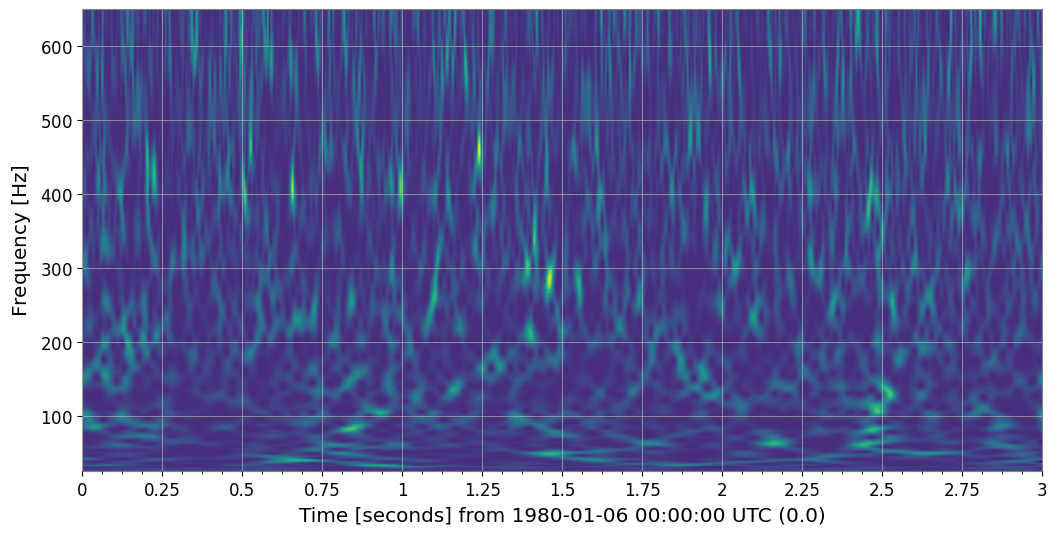

In [10]:
for i in range(20):
    i += 20
    TimeSeries(strain[i][0].numpy(), sample_rate=2048).q_transform(whiten=False, frange=(25, 1024), logf=True).plot()

In [72]:
scaled = datamodule.scale(parameters)

